<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/Alexander_Valle/IA025_CNN_Aula_5_Alexander_Valle__Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nome = 'Rolan Alexander Valle Rey Sánchez'
print(f'Meu nome é {nome}')
ra='230254'
print(f'Meu ra é {ra}')

Meu nome é Rolan Alexander Valle Rey Sánchez
Meu ra é 230254


Este exercicío consiste em treinar no MNIST um modelo de umas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [ ]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [ ]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [ ]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [ ]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [ ]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

<img src="https://ibm.box.com/shared/static/7maczejdeej0qoz3pzkysw0y8qb70g2h.png" alt="HTML5 Icon" style="width: 500px; height: 200px;"> 
<center>  Illustration of the operation for one position of the kernel. <a href="http://colah.github.io/posts/2014-07-Understanding-Convolutions/">ref</a></center>

 <img src="https://ibm.box.com/shared/static/fvutcm8jwa5j2o7xv2zzqyz2yu3zwhz4.gif" alt="HTML5 Icon" style="width: 450px; height: 300px;">

 
<center>  Animations showing how a kernel interact with a matrix representing an image. <a href="http://cs231n.github.io/convolutional-networks/">ref</a></center>  
 

## Padding

![](https://miro.medium.com/max/600/0*r1pPAMPchc80hO3Q.gif)

<center>  Padding. <a href="https://miro.medium.com/max/600/">ref</a></center>  
 
## Strides

![](https://miro.medium.com/max/600/0*tCEq-ytvvZriWsfi.gif)

<center>  Strides. <a href="https://miro.medium.com/max/600/">ref</a></center>  

## Input layer 3, output layer 3, kernel size 3x3, stride 1, padding 0
![](http://www.sharetechnote.com/image/Python_Pytorch_nn_Conv2D_i3_o3_k3_s1_p0.png)

<center>  Input layer 3, output layer 3, kernel size 3x3, stride 1, padding 0. <a href="http://www.sharetechnote.com/image/">ref</a></center>  

## torch.nn.Conv2d(in_channels = n, out_channels = m, kernel_size = k, stride = s, padding = p)
![](http://www.sharetechnote.com/image/Python_Pytorch_nn_Conv2D_Overview_01.png)

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Applies a 2D convolution over an input signal composed of several input
planes.
In the simplest case, the output value of the layer with input size
 $(N, C_{\text{in}}, L)$ and output  $(N,C_{\text{out}}, L_{\text{out}})$ 

can be   precisely described as:

$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +    \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
\star \text{input}(N_i, k)$$

where   $\star$ is the valid 2D $ cross-correlation$ operator,
 $N$ is a batch size,   $C$ denotes a number of channels,
 $L$ is a length of signal sequence.


* **stride** controls the stride for the cross-correlation, a single
  number or a one-element tuple.
* **padding** controls the amount of padding applied to the input. It
  can be either a string {{'valid', 'same'}} or a tuple of ints giving the
  amount of implicit padding applied on both sides.
* **dilation** controls the spacing between the kernel points; also
  known as the à trous algorithm. It is harder to describe, but this `link`_  has a nice visualization of what :attr:`dilation` does.

Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to both sides of
            the input. Default: 0


  Shape:
- Input: $(N, C_{in}, L_{in})$ or $(C_{in}, L_{in})$
- Output: $(N, C_{out}, L_{out})$ or $(C_{out}, L_{out})$, 

where

$L_{out} = \left\lfloor\frac{L_{in} + 2 \times \text{padding} - \text{dilation}\times (\text{kernel_size} - 1) - 1}{\text{stride}} + 1\right\rfloor$

Attributes:

- **weight (Tensor):** the learnable weights of the module of shape
$(\text{out_channels},\frac{\text{in_channels}}{\text{groups}}, \text{kernel_size})$.

The values of these weights are sampled from
$\mathcal{U}(-\sqrt{k}, \sqrt{k})$ 

where $k = \frac{groups}{C_\text{in} * \text{kernel_size}}$


- **bias (Tensor):**  the learnable bias of the module of shape
(out_channels). 

If :attr:  $bias$ is $True$, then the values of these weights aresampled from   $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ 

where
 $k = \frac{groups}{C_\text{in} * \text{kernel_size}}$


In [ ]:
#import math
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def load_state_dict(self,conv_weight,conv_bias):
      self.weight=torch.nn.Parameter(conv_weight)
      self.bias=torch.nn.Parameter(conv_bias)

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'
        # Escreva seu código aqui.
        pad=0
        kz=self.kernel_size
        st=self.stride       

        lenx= x.shape[0]# number of imputs of x
        lenys=self.out_channels# number of outpusts y
        y_lenout1=(x.shape[2]+2*pad-kz)//st+1   #math.ceil((x.shape[2]+2*pad-kz+1)/st)# 
        y_lenout2=(x.shape[3]+2*pad-kz)//st +1#math.ceil((x.shape[3]+2*pad-kz+1)/st)#m

        imgcnv_out=torch.zeros((lenx, lenys, y_lenout1, y_lenout2)) # SHAPE OF THE OUTPUT

        for koutch in range(self.out_channels): # output channels
          for ry, rx in enumerate(range(0, x.shape[3]+2*pad - kz + 1, st)): # scaning rows
            for cy, cx in enumerate(range(0, x.shape[2]+2*pad - kz + 1, st)): # scamimg cols
              xwindow=x[:, :, cx:cx+kz, rx:rx+kz]
              filter=self.weight[koutch, :, :, :]
              #print('xwindow.shape',xwindow.shape)
              #print('filter.shape',filter.shape)
              imgcnv_out[:, koutch, cy, ry] = (filter*xwindow).sum(dim=-1).sum(dim=-1).squeeze()#  function .sum() inspired from patrick_ferreira
              #imgcnv_out[:, koutch, cy, cy] =torch.sum(torch.mul(xwindow, filter))
          imgcnv_out[:, koutch, :, :]+=self.bias[koutch]
        return imgcnv_out

In [ ]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)


In [ ]:
# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

<All keys matched successfully>

In [ ]:
x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [ ]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [ ]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [ ]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 2.303267478942871
Epoch: 1/49 Loss: 2.227701187133789
Epoch: 2/49 Loss: 1.0923895835876465
Epoch: 3/49 Loss: 0.5867355465888977
Epoch: 4/49 Loss: 0.5144088864326477
Epoch: 5/49 Loss: 0.4502663314342499
Epoch: 6/49 Loss: 0.4075140058994293
Epoch: 7/49 Loss: 0.3771387040615082
Epoch: 8/49 Loss: 0.3534485995769501
Epoch: 9/49 Loss: 0.334145188331604
Epoch: 10/49 Loss: 0.3181140422821045
Epoch: 11/49 Loss: 0.3045787811279297
Epoch: 12/49 Loss: 0.29283490777015686
Epoch: 13/49 Loss: 0.2827607989311218
Epoch: 14/49 Loss: 0.2738332748413086
Epoch: 15/49 Loss: 0.26577433943748474
Epoch: 16/49 Loss: 0.2583288848400116
Epoch: 17/49 Loss: 0.2511749863624573
Epoch: 18/49 Loss: 0.24439725279808044
Epoch: 19/49 Loss: 0.23789969086647034
Epoch: 20/49 Loss: 0.2316771149635315
Epoch: 21/49 Loss: 0.22562646865844727
Epoch: 22/49 Loss: 0.21984536945819855
Epoch: 23/49 Loss: 0.21429115533828735
Epoch: 24/49 Loss: 0.2089422345161438
Epoch: 25/49 Loss: 0.20387297868728638
Epoch: 26/49 Loss

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

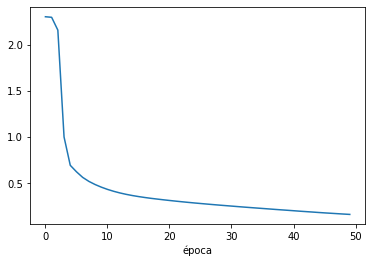

In [ ]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [ ]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923895835876465,
 0.5867355465888977,
 0.5144088864326477,
 0.4502663314342499,
 0.4075140058994293,
 0.3771387040615082,
 0.3534485995769501,
 0.334145188331604,
 0.3181140422821045,
 0.3045787811279297,
 0.29283490777015686,
 0.2827607989311218,
 0.2738332748413086,
 0.26577433943748474,
 0.2583288848400116,
 0.2511749863624573,
 0.24439725279808044,
 0.23789969086647034,
 0.2316771149635315,
 0.22562646865844727,
 0.21984536945819855,
 0.21429115533828735,
 0.2089422345161438,
 0.20387297868728638,
 0.19903433322906494,
 0.19439968466758728,
 0.18994104862213135,
 0.18563994765281677,
 0.18147501349449158,
 0.17744916677474976,
 0.17347252368927002,
 0.16947472095489502,
 0.1654731035232544,
 0.1615048348903656,
 0.1574639081954956,
 0.1534043848514557,
 0.14926917850971222,
 0.14520645141601562,
 0.14123648405075073,
 0.1371268332004547,
 0.13310380280017853,
 0.1291467249393463,
 0.12515074014663696,
 0.12116772681474686,
 0.117317304015

In [ ]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)